In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import *
from matplotlib.patches import Rectangle
from matplotlib.ticker import ScalarFormatter
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.sans-serif'] = 'Arial'

cmap = plt.get_cmap('coolwarm', 9)
colors = cmap(np.linspace(0.1, 0.9, 9))

# Clean data loading
hairtail = pd.read_csv("./Data/cutlassfish_rmNAN.csv")
hairtail_K = hairtail[hairtail['site'] == 'K']
hairtail_T = hairtail[hairtail['site'] == 'T']

hairtail_K.head()

,total_w,gonad_w,newage,site,maturity,mat
0,38.0,0.30,1.0,K,M,1
1,34.5,0.13,1.0,K,M,1
2,34.5,0.31,1.0,K,M,1
3,46.0,0.42,1.5,K,M,1
4,40.0,0.10,1.0,K,M,1


## Linear regression of gonad weight versus total weight

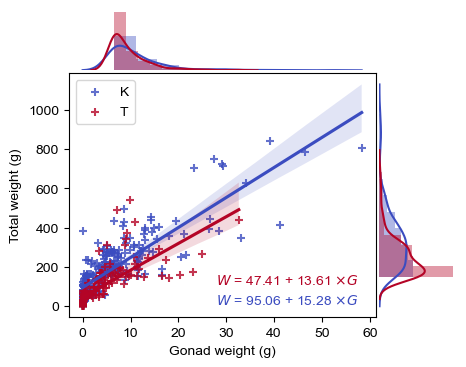

In [2]:
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import statsmodels.formula.api as smf

# Remove outliers by excluding the maximum gonad weight value
max_value = hairtail['gonad_w'].max()
hairtail_ = hairtail[hairtail['gonad_w'] != max_value]

# Split data by site (K and T)
hairtail_K_ = hairtail_[hairtail_['site'] == 'K']
hairtail_T_ = hairtail_[hairtail_['site'] == 'T']

# Figure setup
fig = plt.figure(figsize=(5, 4))
gs = gridspec.GridSpec(2, 2, hspace=0.02, wspace=0.02, width_ratios=[1, 0.25], height_ratios=[0.25, 1])
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[1, 1])
ax3 = plt.subplot(gs[1, 0])

# Top marginal plot (gonad weight distribution)
sns.distplot(hairtail_K_.gonad_w, bins=10, ax=ax1, color=mcolors.rgb2hex(colors[0]))
sns.distplot(hairtail_T_.gonad_w, bins=10, ax=ax1, color=mcolors.rgb2hex(colors[8]))
ax1.axis("off")

# right marginal plot (total weight distribution)
sns.distplot(hairtail_K_.total_w, bins=10, ax=ax2, color=mcolors.rgb2hex(colors[0]), vertical=True)
sns.distplot(hairtail_T_.total_w, bins=10, ax=ax2, color=mcolors.rgb2hex(colors[8]), vertical=True)
ax2.axis("off")

# Main scatter plot with regression lines
sns.regplot(x=hairtail_K_.gonad_w, y=hairtail_K_.total_w, color=colors[0], marker='+', ax=ax3, scatter=True, label="K")
sns.regplot(x=hairtail_T_.gonad_w, y=hairtail_T_.total_w, color=colors[8], marker='+', ax=ax3, scatter=True, label="T")

# Fit linear regression models for both sites
model_K = smf.ols('total_w ~ gonad_w', data=hairtail_K_).fit()
model_T = smf.ols('total_w ~ gonad_w', data=hairtail_T_).fit()

# Extract regression parameters
slope_ECS, intercept_ECS = model_K.params['gonad_w'], model_K.params['Intercept']
slope_SCS, intercept_SCS = model_T.params['gonad_w'], model_T.params['Intercept']

# Create equation strings for annotation
formula_ECS = r"$W$" f' = {intercept_ECS:.2f} + {slope_ECS:.2f} ' r"$\times G$"
formula_SCS = r"$W$" f' = {intercept_SCS:.2f} + {slope_SCS:.2f} ' r"$\times G$"

# Add regression equations to plot
ax3.text(0.48, 0.1, formula_ECS, color=colors[0], transform=ax3.transAxes, fontsize=10, verticalalignment='top')
ax3.text(0.48, 0.18, formula_SCS, color=colors[8], transform=ax3.transAxes, fontsize=10, verticalalignment='top')

# Axis labels and legend
ax3.set_xlabel("Gonad weight (g)")
ax3.set_ylabel("Total weight (g)")
ax3.legend()

# Final layout and saving
plt.tight_layout()
plt.savefig("./Figs/Figure_S9.pdf")
plt.savefig("./Figs/Figure_S9.png", format="png", dpi=600, bbox_inches="tight")

## Analysis of Covariance (ANCOVA)

The ANCOVA tested whether the relationship between gonad weight and total weight differed between sites K and T, while controlling for the effect of gonad weight and assessing potential interaction effects. 

> https://www.statsmodels.org/stable/example_formulas.html

In [3]:
# ANCOVA model: total_w ~ gonad_w * site
# Tests: (1) main effects of gonad weight & site 
#        (2) interaction (slope differences)

import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

model = smf.ols('total_w ~ gonad_w * site', data=hairtail_).fit()  # equivalent to: 'total_w ~ gonad_w + site + gonad_w:site'
print(model.summary())

anova_results = anova_lm(model)
print(anova_results)

                            OLS Regression Results                            
Dep. Variable:                total_w   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     300.6
Date:                Sun, 21 Sep 2025   Prob (F-statistic):          4.97e-101
Time:                        19:51:10   Log-Likelihood:                -2279.7
No. Observations:                 394   AIC:                             4567.
Df Residuals:                     390   BIC:                             4583.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            95.0613      6.20

## Uncertainty quantification for $Ap_{50}$ and $Wp_{50}$

In [4]:
from bootstrap_func import bootstrap_Xp50

np.random.seed(42)

n_bootstrap=2000
results = {}  # store all bootstrap results
name_index = 0  # Name counter initialization
Xp_names = ['Ap50_K', 'Wp50_K', 'Ap50_T', 'Wp50_T']  # Predefined output variable names

# Iterative bootstrap analysis procedure
for i, df in enumerate([hairtail_K, hairtail_T]):
    site = 'K' if i == 0 else 'T'
    for var in ['newage', 'total_w']:
        current_name = Xp_names[name_index]
        name_index += 1
        results[current_name] = bootstrap_Xp50(df[var], df['mat'], n_bootstrap=n_bootstrap)
        
        # Print summary statistics
        print(f"\n{current_name} Summary Statistics:")
        print(f"• Mean: {np.mean(results[current_name]):.3f}")
        print(f"• 95% CI: [{np.percentile(results[current_name], 2.5):.3f}, "
              f"{np.percentile(results[current_name], 97.5):.3f}]")

# Convert results to tidy DataFrame format
results_df = pd.DataFrame({
    'Iteration': np.tile(range(1, n_bootstrap+1), len(Xp_names)),
    'Value': np.concatenate([results[name] for name in Xp_names]),
    'Variable': np.repeat(Xp_names, n_bootstrap)})

results_df.to_csv('./Data/Xp50_results.csv', index=False)


Ap50_K Summary Statistics:
• Mean: 1.550
• 95% CI: [1.336, 1.756]

Wp50_K Summary Statistics:
• Mean: 82.373
• 95% CI: [62.020, 101.167]

Ap50_T Summary Statistics:
• Mean: 1.084
• 95% CI: [0.889, 1.282]

Wp50_T Summary Statistics:
• Mean: 50.567
• 95% CI: [39.517, 62.591]


## Age at maturation

The below cells generates a 2x2 panel figure comparing:
1. Logistic MM for maturity schedules (Top row) for two study sites (K and T).
2. Deep BQMM for maturity schedules (Bottom row) for two study sites (K and T).

Key Components:
- Panel (a): Logistic model fit probability of maturity for Site K.
- Panel (b): Logistic model fit probability of maturity for Site T.
- Panel (c): Deep Quantile regression curves with quantile of maturity inset for Site K.
- Panel (d): Deep Quantile regression curves with quantile of maturity inset for Site T.

Accuracy on the test set of site K: 82.00%
Ap50_K:  1.4890306685770116
Accuracy on the test set of site T: 76.67%
Ap50_T:  1.1619832724451984
Torch Device: cpu
[5/20] Test Acc Q : 0.820000  
[10/20] Test Acc Q : 0.820000  
[15/20] Test Acc Q : 0.880000  
[20/20] Test Acc Q : 0.880000  
Torch Device: cpu
[5/20] Test Acc Q : 0.766667  
[10/20] Test Acc Q : 0.766667  
[15/20] Test Acc Q : 0.766667  
[20/20] Test Acc Q : 0.766667  


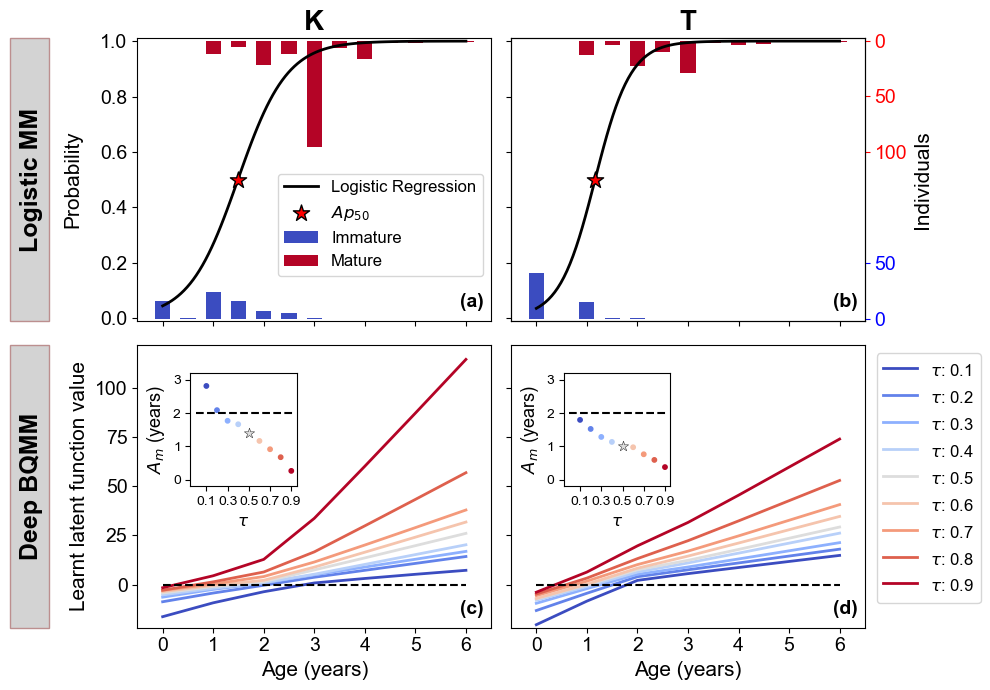

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7), sharex=True, sharey="row")

# ======================================================================
# Panel (a): Logistic Regression Analysis - Site K
# ======================================================================

x = hairtail_K.newage
y = hairtail_K.mat
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train = x_train.to_numpy().reshape(-1, 1)
x_test = x_test.to_numpy().reshape(-1, 1)
x_values = np.linspace(hairtail_K.newage.min(), hairtail_K.newage.max(), 100)

# Initialize and fit logistic regression model
model = LogisticRegression()
model.fit(x_train, y_train)  

# Model evaluation and prediction
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on the test set of site K: {:.2f}%".format(accuracy * 100))
probabilities = model.predict_proba(x_values.reshape(-1, 1))[:, 1]

# Calculate Ap50 and Apx
logis_K = []
target_probabilities = np.linspace(0.1, 0.9, 9)
x_values_for_target_probabilities = []
for probability in target_probabilities:
    x_value_for_target_probability = (np.log(probability / (1 - probability)) - model.intercept_) / model.coef_.flatten()
    x_values_for_target_probabilities.append(x_value_for_target_probability[0])
    if probability == 0.5:
        Ap50_K = x_value_for_target_probability[0]
        print("Ap50_K: ", Ap50_K)
logis_K.append(x_values_for_target_probabilities)

# Plot logistic curve and Ap50 marker
ax[0,0].plot(x_values, probabilities, color='k', lw=2, label='Logistic Regression')
# Star marker for Ap50
ax[0,0].scatter(Ap50_K, 0.5, marker='*', s=150, facecolors='red', edgecolors='black', zorder=10, label=r'$Ap_{50}$') 

# Configure axes
ax[0,0].set(xlim=(-0.5, 6.5), ylim=(-0.01, 1.01))
ax[0,0].tick_params(axis='y', labelsize=14)
ax[0,0].set_ylabel("Probability", fontsize=15, labelpad=13)
ax[0,0].set_title("K", fontsize=20, fontweight='bold')

# Create bar plots for immature/mature distributions
ax1 = ax[0,0].twinx()  # ax1：Immature distribution (blue bars)
freq_K_im = hairtail_K[hairtail_K.mat == 0].newage.value_counts().sort_index()
ax1.bar(x=np.array(freq_K_im.index), height=np.array(freq_K_im), width=0.3, color=colors[0], label='Immature')
ax1.set(ylim=(-2, 252))
ax1.set_yticks([0, 50, 150, 200, 250])
labels = ['0', '50', '100', '50', '0']
ax1.set_yticklabels(labels)

# Color ticks differently for visual distinction
for i, tick_label in enumerate(ax1.get_yticklabels()):
    if i < 2:
        tick_label.set_color('blue')
    else:
        tick_label.set_color('red')
ax1.set_axis_off()  # Hide axis

ax2 = ax[0,0].twinx()  # Ax2: Mature distribution (red bars, inverted)
ax2.invert_yaxis()
ax2.spines.right.set_position(("axes", 1.15))
freq_K_m = hairtail_K[hairtail_K.mat == 1].newage.value_counts().sort_index()
ax2.bar(x=np.array(freq_K_m.index), height=np.array(freq_K_m), width=0.3, color=colors[-1], label='Mature')
ax2.set(ylim=(252, -2))
ax2.set_axis_off()

ax1.set_zorder(ax2.get_zorder()+1) 
ax[0, 0].set_zorder(ax1.get_zorder()+1) 
ax[0, 0].patch.set_visible(False) 

legend_handles = [ax[0,0].get_legend_handles_labels()[0][0],
                  ax[0,0].get_legend_handles_labels()[0][1],
                  ax1.get_legend_handles_labels()[0][0],
                  ax2.get_legend_handles_labels()[0][0]]
ax[0,0].legend(handles=legend_handles, fontsize=12, loc='lower right', bbox_to_anchor=(1, 0.13))


# ======================================================================
# Panel (b): Logistic Regression Analysis - Site T 
# Code comments omitted (Parallel implementation to Panel a with Site T data)
# ======================================================================

x = hairtail_T.newage
y = hairtail_T.mat
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train = x_train.to_numpy().reshape(-1, 1)
x_test = x_test.to_numpy().reshape(-1, 1)
x_values = np.linspace(hairtail_T.newage.min(), hairtail_T.newage.max(), 100)
model = LogisticRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on the test set of site T: {:.2f}%".format(accuracy * 100))
probabilities = model.predict_proba(x_values.reshape(-1, 1))[:, 1]

logis_T = []
target_probabilities = np.linspace(0.1, 0.9, 9)
x_values_for_target_probabilities = []
for probability in target_probabilities:
    x_value_for_target_probability = (np.log(probability / (1 - probability)) - model.intercept_) / model.coef_.flatten()
    x_values_for_target_probabilities.append(x_value_for_target_probability[0])
    if probability == 0.5:
        Ap50_T = x_value_for_target_probability[0]
        print("Ap50_T: ", Ap50_T)
logis_T.append(x_values_for_target_probabilities)

ax[0,1].plot(x_values, probabilities, color='k', lw=2)
ax[0,1].scatter(Ap50_T, 0.5, marker='*', s=150, facecolors='red', edgecolors='black', zorder=10)
ax[0,1].set(xlim=(-0.5, 6.5), ylim=(-0.01, 1.01))
ax[0,1].set_title("T", fontsize=20, fontweight='bold')

ax1 = ax[0,1].twinx()
freq_T_im = hairtail_T[hairtail_T.mat == 0].newage.value_counts().sort_index()
ax1.bar(x=np.array(freq_T_im.index), height=np.array(freq_T_im), width=0.3, color=colors[0], label='Immature')
ax1.set(ylim=(-2, 252))
ax1.set_yticks([0, 50, 150, 200, 250])
labels = ['0', '50', '100', '50', '0']
ax1.set_yticklabels(labels)
ax1.set_ylabel('Individuals', fontsize=15)
ax1.tick_params(axis='y', labelsize=14)

for i, tick_label in enumerate(ax1.get_yticklabels()):
    if i < 2:
        tick_label.set_color('blue')
    else:
        tick_label.set_color('red')
for i, tick in enumerate(ax1.yaxis.get_major_ticks()):
    if i < 2:
        tick.tick2line.set_markeredgecolor('blue')
    else:
        tick.tick2line.set_markeredgecolor('red')

ax2 = ax[0,1].twinx()
ax2.invert_yaxis()
ax2.spines.right.set_position(("axes", 1.15))
freq_T_m = hairtail_T[hairtail_T.mat == 1].newage.value_counts().sort_index()
ax2.bar(x=np.array(freq_T_m.index), height=np.array(freq_T_m), width=0.3, color=colors[-1], label='Mature')
ax2.set(ylim=(252, -2))
ax2.set_axis_off()

ax1.set_zorder(ax2.get_zorder()+1) 
ax[0, 1].set_zorder(ax1.get_zorder()+1) 
ax[0, 1].patch.set_visible(False) 


# ======================================================================
# Panel (c): Deep Binary Quantile Regression - Site K
# ======================================================================

# Deep Binary Quantile Regression
attribute_array_K, outputs_K = BQR('./Data/cutlassfish_siteK_rmNAN.csv',
                                   batch_is=64,  # Batch size
                                   x_cols=[2],  # Column index for independent variable
                                   y_col=5,  # Column index for dependent variable
                                   attribute_index=0,  # Attribute index
                                   attribute_name="newage_K",  # Attribute name
                                   latent_name="Maturity",  # Latent variable name
                                   total_epochs=20,  # Training epochs
                                   ndim=1)  # Dimension of input

# Plot quantile curves (τ = 0.1 to 0.9)
for i in range(9):
    ax[1,0].plot(attribute_array_K, outputs_K[i], color=colors[i], lw=2)
ax[1,0].plot([min(attribute_array_K), max(attribute_array_K)],[0,0], linestyle="dashed", c="k") # Reference line

# Set axis limits and labels
ax[1,0].set_ylim(-22, 122)
ax[1,0].tick_params(axis='x', labelsize=14)
ax[1,0].tick_params(axis='y', labelsize=14)
ax[1,0].set_xlabel('Age (years)', fontsize=15)
ax[1,0].set_ylabel("Learnt latent function value", fontsize=15)

# Calculate intersection points 
intersections_K = []
for i in outputs_K[::-1]:
    intersections = calculate_intersections([0, 1, 2, 3, 4, 5, 6], i)
    intersections_K.append(intersections)

# Create inset plot
axins = ax[1, 0].inset_axes((0.15, 0.5, 0.3, 0.4))
mask = ~np.isclose(np.arange(0.1, 1, 0.1), 0.5)
axins.scatter(np.arange(0.1, 1, 0.1)[mask], np.array(intersections_K[::-1])[mask], color=colors[mask], s=10)
axins.scatter(0.5, intersections_K[::-1][4], color=colors[4], marker='*',  # Star marker
              s=60, edgecolor='k', linewidth=0.3, zorder=10)
axins.plot([0, 0.92], [2, 2], linestyle="dashed", c="k")  # Reference line

# Configure inset axes
axins.set_xlim(-0.05, 0.95)
axins.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
axins.set_xticklabels(['0.1', '0.3', '0.5', '0.7', '0.9'])
axins.set_xlabel(r"$\tau$", fontsize=12)
axins.set_ylim(-0.2, 3.2)
axins.set_yticks([0, 1, 2, 3])
axins.set_yticklabels(['0','1','2', '3'])
axins.set_ylabel(r'$A_{m}$ (years)', fontsize=13)
axins.grid(False)


# ======================================================================
# Panel (d): Deep Binary Quantile Regression - Site T
# Code comments omitted (Parallel implementation to Panel c with Site T data)
# ======================================================================

attribute_array_T, outputs_T = BQR('./Data/cutlassfish_siteT_rmNAN.csv',
                                   batch_is=64,
                                   x_cols=[2],
                                   y_col=5,
                                   attribute_index=0,
                                   attribute_name="newage_T",
                                   latent_name="Maturity",
                                   total_epochs=20,
                                   ndim=1)

for i in range(9):
    ax[1,1].plot(attribute_array_T, outputs_T[i], color=colors[i], lw=2, label=r"$\tau$: " + "0."+str(i+1))
ax[1,1].plot([min(attribute_array_T), max(attribute_array_T)],[0,0], linestyle="dashed", c="k")
ax[1,1].tick_params(axis='x', labelsize=14)
ax[1,1].set_xlabel('Age (years)', fontsize=15)
ax[1,1].legend(ncol=1, handleheight=1.57, labelspacing=0.35, fontsize=12, bbox_to_anchor=(1.01, 1))

intersections_T = []
for i in outputs_T[::-1]:
    intersections = calculate_intersections([0, 1, 2, 3, 4, 5, 6], i)
    intersections_T.append(intersections)
    
axins = ax[1, 1].inset_axes((0.15, 0.5, 0.3, 0.4))
mask = ~np.isclose(np.arange(0.1, 1, 0.1), 0.5)
axins.scatter(np.arange(0.1, 1, 0.1)[mask], np.array(intersections_T[::-1])[mask], color=colors[mask], s=10)
axins.scatter(0.5, intersections_T[::-1][4], color=colors[4], marker='*', s=60, edgecolor='k', linewidth=0.3, zorder=10)
axins.plot([0, 0.92], [2, 2], linestyle="dashed", c="k")
axins.set_xlim(-0.05, 0.95)
axins.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
axins.tick_params(axis='x', labelsize=10)
axins.set_xticklabels(['0.1', '0.3', '0.5', '0.7', '0.9'])
axins.set_xlabel(r"$\tau$", fontsize=12)
axins.set_ylim(-0.2, 3.2)
axins.set_yticks([0, 1, 2, 3])
axins.tick_params(axis='y', labelsize=10)
axins.set_yticklabels(['0','1','2', '3'])
axins.set_ylabel(r'$A_{m}$ (years)', fontsize=13)
axins.grid(False)

######################################################################################################################

# Add model type labels
annotations = ['Logistic MM', 'Deep BQMM']
for i, ax_ in enumerate(ax[:, 0]):
    ax_.annotate(annotations[i], xy=(-0.30, 0.5), xycoords='axes fraction', fontsize=18, fontweight='bold',
                 rotation=90, ha='center', va='center')

    rectangle = Rectangle((-0.36, 0), 0.11, 1, transform=ax_.transAxes, facecolor="lightgray", edgecolor="rosybrown", clip_on=False)
    ax_.add_patch(rectangle)

# Add panel labels
Alphbeta = ['a', 'b', 'c', 'd']
for i, ax_ in enumerate(ax.flatten()):
    ax_.text(float(0.98), float(0.05), '('+ Alphbeta[i]+')', transform=ax_.transAxes, ha='right', fontsize=14, fontweight='bold')

# Adjust layout and save figure
plt.tight_layout()
plt.savefig("./Figs/Figure_3.pdf")
plt.savefig("./Figs/Figure_3.png", format="png", dpi=600, bbox_inches="tight")

## The correspondence between Logistic MM probability values and deep BQMM zero points

Accuracy on the test set of site K: 82.00%
Ap50_K:  1.4890306685770116
Torch Device: cpu
[5/20] Test Acc Q : 0.820000  
[10/20] Test Acc Q : 0.820000  
[15/20] Test Acc Q : 0.880000  
[20/20] Test Acc Q : 0.880000  
Accuracy on the test set of site T: 76.67%
Ap50_T:  1.1619832724451984
Torch Device: cpu
[5/20] Test Acc Q : 0.766667  
[10/20] Test Acc Q : 0.766667  
[15/20] Test Acc Q : 0.766667  
[20/20] Test Acc Q : 0.766667  


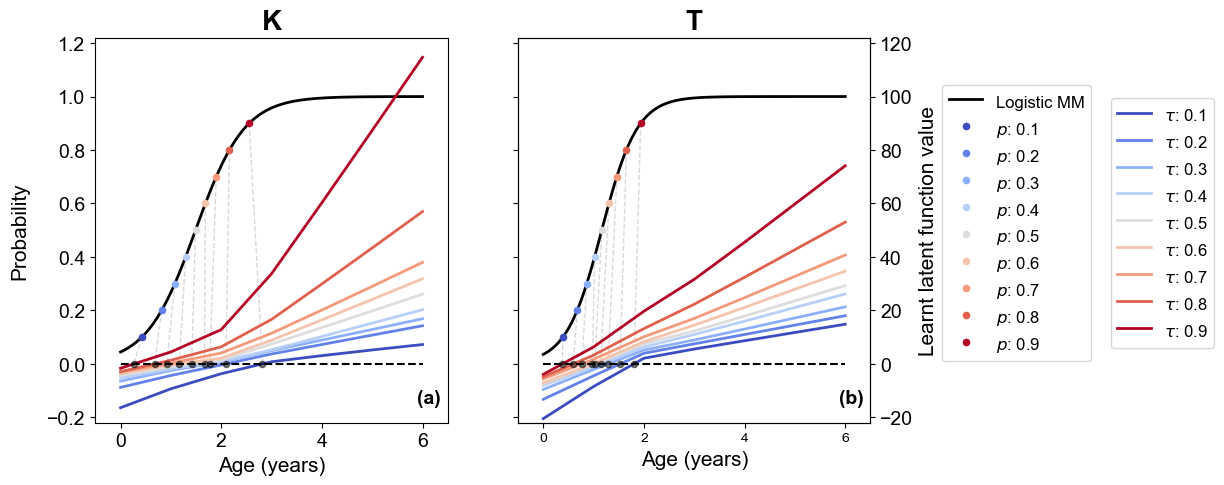

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

# ======================================================================
# Panel (a): Logistic MM vs deep BQMM Analysis - Site K
# ======================================================================

x = hairtail_K.newage
y = hairtail_K.mat
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train = x_train.to_numpy().reshape(-1, 1)
x_test = x_test.to_numpy().reshape(-1, 1)
x_values = np.linspace(hairtail_K.newage.min(), hairtail_K.newage.max(), 100)

# Initialize and fit logistic regression model
model = LogisticRegression()
model.fit(x_train, y_train)  

# Model evaluation and prediction
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on the test set of site K: {:.2f}%".format(accuracy * 100))
probabilities = model.predict_proba(x_values.reshape(-1, 1))[:, 1]

# Calculate Ap50 and Apx
logis_K = []
target_probabilities = np.linspace(0.1, 0.9, 9)
x_values_for_target_probabilities = []
for probability in target_probabilities:
    x_value_for_target_probability = (np.log(probability / (1 - probability)) - model.intercept_) / model.coef_.flatten()
    x_values_for_target_probabilities.append(x_value_for_target_probability[0])
    if probability == 0.5:
        Ap50_K = x_value_for_target_probability[0]
        print("Ap50_K: ", Ap50_K)
logis_K.append(x_values_for_target_probabilities)

# Plot logistic curve
ax[0].plot(x_values, probabilities, color='k', lw=2, label='Logistic MM')

# Mark target probabilities on logistic curve
for j, prob in enumerate(target_probabilities):
    ax[0].scatter(x_values_for_target_probabilities[j], prob, color=colors[j], s=20, zorder=5,
                  label=r"$p$: "+f"{prob:.1f}")

# Configure axes
ax[0].set(xlim=(-0.5, 6.5), ylim=(-0.22, 1.22))
ax[0].tick_params(axis='y', labelsize=14)
ax[0].set_xlabel('Age (years)', fontsize=15)
ax[0].tick_params(axis='x', labelsize=14)
ax[0].set_ylabel("Probability", fontsize=15, labelpad=13)
ax[0].set_title("K", fontsize=20, fontweight='bold')
ax[0].legend(ncol=1, handleheight=1.57, labelspacing=0.35, fontsize=12, bbox_to_anchor=(2.85, 0.9))



ax1 = ax[0].twinx()

# Deep Binary Quantile Regression
attribute_array_K, outputs_K = BQR('./Data/cutlassfish_siteK_rmNAN.csv',
                                   batch_is=64,  # Batch size
                                   x_cols=[2],  # Column index for independent variable
                                   y_col=5,  # Column index for dependent variable
                                   attribute_index=0,  # Attribute index
                                   attribute_name="newage_K",  # Attribute name
                                   latent_name="Maturity",  # Latent variable name
                                   total_epochs=20,  # Training epochs
                                   ndim=1)  # Dimension of input

# Plot quantile curves (τ = 0.1 to 0.9)
for i in range(9):
    ax1.plot(attribute_array_K, outputs_K[i], color=colors[i], lw=2)
ax1.plot([min(attribute_array_K), max(attribute_array_K)],[0,0], linestyle="dashed", c="k") # Reference line

# Set axis limits and labels
ax1.set_ylim(-22, 122)
ax1.tick_params(axis='x', labelsize=14)
ax1.set_axis_off()  # Hide axis

# Calculate the zero points of the learnt latent function
intersections_K = []
for i in outputs_K[::-1]:
    intersections = calculate_intersections([0, 1, 2, 3, 4, 5, 6], i)
    intersections_K.append(intersections)

# plot learnt latent function
ax1.scatter(intersections_K, np.repeat(0, len(target_probabilities)), s=20, color='k', alpha=0.5, zorder=10)

# Connecting the logistic probability points to the zero points of the learnt latent function.
for i in range(len(target_probabilities)):
    ax[0].plot([x_values_for_target_probabilities[i], intersections_K[i]], [target_probabilities[i], 0], 
               color='gray', alpha=0.3, linestyle='--', linewidth=1)
# ======================================================================
# Panel (b): Logistic MM vs deep BQMM Analysis - Site T 
# Code comments omitted (Parallel implementation to Panel a with Site T data)
# ======================================================================

x = hairtail_T.newage
y = hairtail_T.mat
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train = x_train.to_numpy().reshape(-1, 1)
x_test = x_test.to_numpy().reshape(-1, 1)
x_values = np.linspace(hairtail_T.newage.min(), hairtail_T.newage.max(), 100)
model = LogisticRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on the test set of site T: {:.2f}%".format(accuracy * 100))
probabilities = model.predict_proba(x_values.reshape(-1, 1))[:, 1]

logis_T = []
target_probabilities = np.linspace(0.1, 0.9, 9)
x_values_for_target_probabilities = []
for probability in target_probabilities:
    x_value_for_target_probability = (np.log(probability / (1 - probability)) - model.intercept_) / model.coef_.flatten()
    x_values_for_target_probabilities.append(x_value_for_target_probability[0])
    if probability == 0.5:
        Ap50_T = x_value_for_target_probability[0]
        print("Ap50_T: ", Ap50_T)
logis_T.append(x_values_for_target_probabilities)

ax[1].plot(x_values, probabilities, color='k', lw=2)

for j, prob in enumerate(target_probabilities):
    ax[1].scatter(x_values_for_target_probabilities[j], prob, color=colors[j], s=20, zorder=5,
                  label=f"p={prob:.1f}")

ax[1].set_title("T", fontsize=20, fontweight='bold')
ax[1].set_xlabel('Age (years)', fontsize=15)

ax2 = ax[1].twinx()

attribute_array_T, outputs_T = BQR('./Data/cutlassfish_siteT_rmNAN.csv',
                                   batch_is=64,
                                   x_cols=[2],
                                   y_col=5,
                                   attribute_index=0,
                                   attribute_name="newage_T",
                                   latent_name="Maturity",
                                   total_epochs=20,
                                   ndim=1)

for i in range(9):
    ax2.plot(attribute_array_T, outputs_T[i], color=colors[i], lw=2, label=r"$\tau$: " + "0."+str(i+1))
ax2.plot([min(attribute_array_T), max(attribute_array_T)],[0,0], linestyle="dashed", c="k")
ax2.tick_params(axis='x', labelsize=14)
ax2.set_xlabel('Age (years)', fontsize=15)
ax2.set_ylim(-22, 122)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_ylabel("Learnt latent function value", fontsize=15)
# ax2.legend(ncol=2, handleheight=1.57, labelspacing=0.35, fontsize=12, bbox_to_anchor=(1.01, 1))
ax2.legend(ncol=1, handleheight=1.57, labelspacing=0.35, fontsize=12, bbox_to_anchor=(2, 0.865))

intersections_T = []
for i in outputs_T[::-1]:
    intersections = calculate_intersections([0, 1, 2, 3, 4, 5, 6], i)
    intersections_T.append(intersections)

ax2.scatter(intersections_T, np.repeat(0, len(target_probabilities)), s=20, color='k', alpha=0.5, zorder=10)

for i in range(len(target_probabilities)):
    ax[1].plot([x_values_for_target_probabilities[i], intersections_T[i]], 
               [target_probabilities[i], 0], 
               color='gray', alpha=0.3, linestyle='--', linewidth=1)
######################################################################################################################

# Add panel labels
Alphbeta = ['a', 'b']
for i, ax_ in enumerate(ax.flatten()):
    ax_.text(float(0.98), float(0.05), '('+ Alphbeta[i]+')', transform=ax_.transAxes, ha='right', fontsize=14, fontweight='bold')

# Adjust layout and save figure
plt.tight_layout()
plt.savefig("./Figs/Figure_S8.pdf")
plt.savefig("./Figs/Figure_S8.png", format="png", dpi=600, bbox_inches="tight")

## Logistic MM vs. deep BQMM on predicting $A_m$

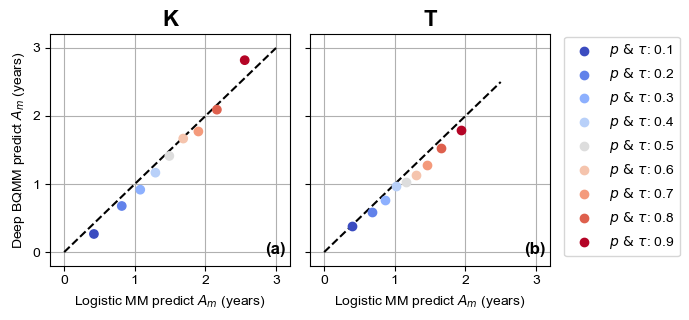

In [7]:
intersections_K = []
for i in outputs_K[::-1]:
    intersections = calculate_intersections([0, 1, 2, 3, 4, 5, 6], i)
    intersections_K.append(intersections)

intersections_T = []
for i in outputs_T[::-1]:
    intersections = calculate_intersections([0, 1, 2, 3, 4, 5, 6], i)
    intersections_T.append(intersections)

fig, ax = plt.subplots(1, 2, figsize=(7, 3.3), sharex=True, sharey=True)
ax[0].scatter(logis_K[0], intersections_K, color=colors, zorder=10)
ax[0].plot(np.linspace(0, 3, 100), np.linspace(0, 3, 100), color='k', linestyle='--')
ax[0].set_xlim(-0.2, 3.2)
ax[0].set_xticks([0, 1, 2, 3], [0, 1 , 2, 3])
ax[0].set_xlabel(r'Logistic MM predict $A_{m}$ (years)')
ax[0].set_ylim(-0.2, 3.2)
ax[0].set_yticks([0, 1, 2, 3], [0, 1 , 2, 3])
ax[0].set_ylabel('Deep BQMM predict $A_{m}$ (years)')
ax[0].set_title('K', fontweight='bold', fontsize=16)
ax[0].grid(True)

for i in range(len(logis_T[0])):
    plt.scatter(logis_T[0][i], intersections_T[i], color=colors[i], zorder=10, label=r'$p \ & \ \tau$: ' +f'{i/10+0.1:.1f}')
ax[1].plot(np.linspace(0, 2.5, 100), np.linspace(0, 2.5, 100), color='k', linestyle='--')
ax[1].set_xlabel(r'Logistic MM predict $A_{m}$ (years)')
ax[1].set_title('T', fontweight='bold', fontsize=16)
ax[1].grid(True)
ax[1].legend(loc='upper left', ncol=1, bbox_to_anchor=(1.03, 1.02))

Alphbeta = ['a', 'b']
for i, ax_ in enumerate(ax.flatten()):
    ax_.text(float(0.98), float(0.05), '('+ Alphbeta[i]+')', transform=ax_.transAxes, ha='right', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig("./Figs/Figure_S7.pdf")
plt.savefig("./Figs/Figure_S7.png", format="png", dpi=600, bbox_inches="tight")

## Weight at maturation

The below cells generates a 2x2 panel figure comparing:
1. Logistic MM for maturity schedules (Top row) for two study sites (K and T).
2. Deep BQMM for maturity schedules (Bottom row) for two study sites (K and T).

Key Components:
- Panel (a): Logistic model fit probability of maturity for Site K.
- Panel (b): Logistic model fit probability of maturity for Site T.
- Panel (c): Deep Quantile regression curves with quantile of maturity inset for Site K.
- Panel (d): Deep Quantile regression curves with quantile of maturity inset for Site T.

Accuracy on the test set of site K: 82.00%
Wp50_K:  78.37370655728398
Accuracy on the test set of site T: 76.67%
Wp50_T:  55.71226609933601
Torch Device: cpu
[5/20] Test Acc Q : 0.680000  
[10/20] Test Acc Q : 0.840000  
[15/20] Test Acc Q : 0.860000  
[20/20] Test Acc Q : 0.820000  
Torch Device: cpu
[5/20] Test Acc Q : 0.666667  
[10/20] Test Acc Q : 0.700000  
[15/20] Test Acc Q : 0.766667  
[20/20] Test Acc Q : 0.833333  


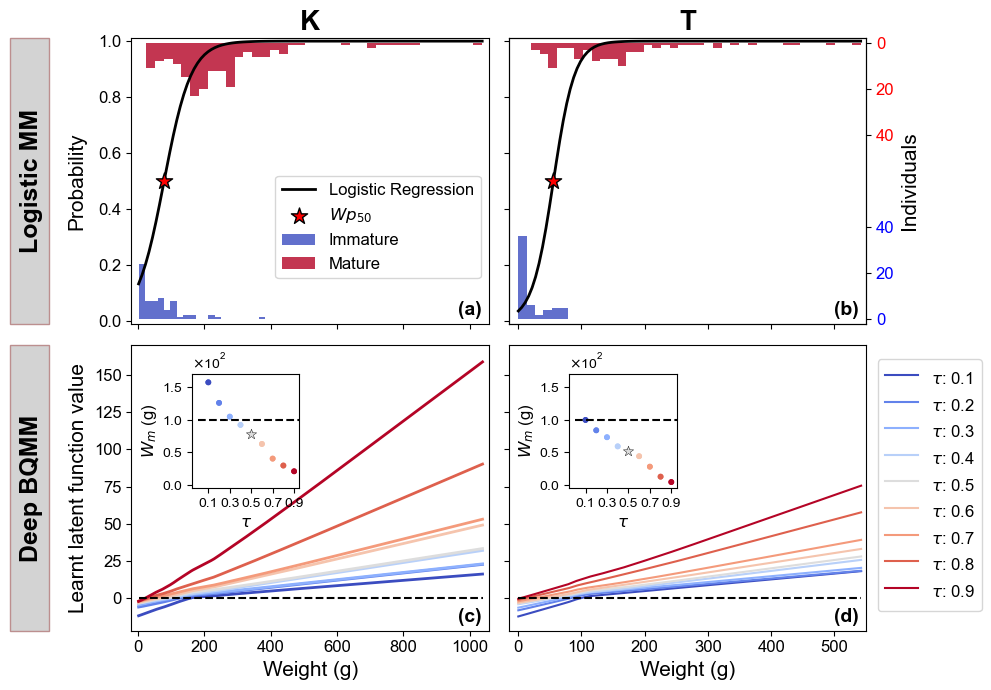

In [8]:
# ======================================================================
# Code comments omitted (Parallel implementation to Age at maturation (Figure 4))
# ======================================================================

fig, ax = plt.subplots(2, 2, figsize=(10, 7), sharex="col", sharey="row")

cmap = plt.get_cmap('coolwarm', 9)
colors = cmap(np.linspace(0.1, 0.9, 9))

x = hairtail_K.total_w
y = hairtail_K.mat
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train = x_train.to_numpy().reshape(-1, 1)
x_test = x_test.to_numpy().reshape(-1, 1)
x_values = np.linspace(hairtail_K.total_w.min(), hairtail_K.total_w.max(), 100)
model = LogisticRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on the test set of site K: {:.2f}%".format(accuracy * 100))
probabilities = model.predict_proba(x_values.reshape(-1, 1))[:, 1]

target_probabilities = np.linspace(0.1, 0.9, 9)
x_values_for_target_probabilities = []
for probability in target_probabilities:
    x_value_for_target_probability = (np.log(probability / (1 - probability)) - model.intercept_) / model.coef_.flatten()
    x_values_for_target_probabilities.append(x_value_for_target_probability[0])
    if probability == 0.5:
        Wp50_K = x_value_for_target_probability[0]
        print("Wp50_K: ", Wp50_K)

ax[0,0].plot(x_values, probabilities, color='k', lw=2, label='Logistic Regression')
ax[0,0].scatter(Wp50_K, 0.5, marker='*', s=150, facecolors='red', edgecolors='black', zorder=10, label=r'$Wp_{50}$')
ax[0,0].set(xlim=(-20, 1080), ylim=(-0.01, 1.01))
ax[0,0].tick_params(axis='y', labelsize=12)
ax[0,0].set_ylabel("Probability", fontsize=15, labelpad=9)
ax[0,0].set_title('K', fontsize=20, fontweight='bold', color='k')

ax1 = ax[0,0].twinx()
ax1.hist(x=np.array(hairtail_K[hairtail_K.mat == 0].total_w), bins=20, color=colors[0], alpha=0.8, label='Immature')
ax1.set(ylim=(-2, 122))
ax1.set_yticks([0, 20, 40, 80, 100, 120])
labels = ['0', '20', '40', '40', '20', '0']
ax1.set_yticklabels(labels)
for i, tick_label in enumerate(ax1.get_yticklabels()):
    if i < 3:
        tick_label.set_color('blue')
    else:
        tick_label.set_color('red')
ax1.set_axis_off()
        
ax2 = ax[0,0].twinx()
ax2.invert_yaxis()
ax2.spines.right.set_position(("axes", 1.15))
ax2.hist(x=np.array(hairtail_K[hairtail_K.mat == 1].total_w), bins=38, color=colors[-1], alpha=0.8, label='Mature')
ax2.set(ylim=(122, -2))
ax2.set_axis_off()

ax1.set_zorder(ax2.get_zorder()+1) 
ax[0, 0].set_zorder(ax1.get_zorder()+1) 
ax[0, 0].patch.set_visible(False) 

legend_handles = [ax[0,0].get_legend_handles_labels()[0][0],
                  ax[0,0].get_legend_handles_labels()[0][1],
                  ax1.get_legend_handles_labels()[0][0],
                  ax2.get_legend_handles_labels()[0][0]]
ax[0,0].legend(handles=legend_handles, fontsize=12, loc='lower right', bbox_to_anchor=(1, 0.13))

######################################################################################################################

x = hairtail_T.total_w
y = hairtail_T.mat
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train = x_train.to_numpy().reshape(-1, 1)
x_test = x_test.to_numpy().reshape(-1, 1)
x_values = np.linspace(hairtail_T.total_w.min(), hairtail_T.total_w.max(), 100)
model = LogisticRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on the test set of site T: {:.2f}%".format(accuracy * 100))
probabilities = model.predict_proba(x_values.reshape(-1, 1))[:, 1]

target_probabilities = np.linspace(0.1, 0.9, 9)
x_values_for_target_probabilities = []
for probability in target_probabilities:
    x_value_for_target_probability = (np.log(probability / (1 - probability)) - model.intercept_) / model.coef_.flatten()
    x_values_for_target_probabilities.append(x_value_for_target_probability[0])
    if probability == 0.5:
        Wp50_T = x_value_for_target_probability[0]
        print("Wp50_T: ", Wp50_T)

ax[0,1].plot(x_values, probabilities, color='k', lw=2)
ax[0,1].scatter(Wp50_T, 0.5, marker='*', s=150, facecolors='red', edgecolors='black', zorder=10)
ax[0,1].set(xlim=(-15, 550), ylim=(-0.01, 1.01))
ax[0,1].set_title('T', fontsize=20, fontweight='bold', color='k')

ax1 = ax[0,1].twinx()
ax1.hist(x=np.array(hairtail_T[hairtail_T.mat == 0].total_w), bins=6, color=colors[0], alpha=0.8, label='Immature')
ax1.set(ylim=(-2, 122))
ax1.tick_params(axis='y', labelsize=12)
ax1.set_yticks([0, 20, 40, 80, 100, 120])
labels = ['0', '20', '40', '40', '20', '0']
ax1.set_yticklabels(labels)
ax1.set_ylabel('Individuals', fontsize=15)
for i, tick_label in enumerate(ax1.get_yticklabels()):
    if i < 3:
        tick_label.set_color('blue')
    else:
        tick_label.set_color('red')

ax2 = ax[0,1].twinx()
ax2.invert_yaxis()
ax2.spines.right.set_position(("axes", 1.15))
freq_T_m = hairtail_T[hairtail_T.mat == 1].newage.value_counts().sort_index()
ax2.hist(x=np.array(hairtail_T[hairtail_T.mat == 1].total_w), bins=38, color=colors[-1], alpha=0.8, label='Mature')
ax2.set(ylim=(122, -2))
ax2.set_axis_off()

ax1.set_zorder(ax2.get_zorder()+1) 
ax[0, 1].set_zorder(ax1.get_zorder()+1) 
ax[0, 1].patch.set_visible(False) 

######################################################################################################################

attribute_array_K, outputs_K = BQR('./Data/cutlassfish_siteK_rmNAN.csv',
                                   batch_is=64,
                                   x_cols=[0],
                                   y_col=5,
                                   attribute_index=0,
                                   attribute_name="total_weight",
                                   latent_name="Maturity",
                                   total_epochs=20,
                                   ndim=1)

for i in range(9):
    ax[1,0].plot(attribute_array_K, outputs_K[i], color=colors[i], lw=2)
ax[1,0].plot([min(attribute_array_K), max(attribute_array_K)],[0,0], linestyle="dashed", c="k")
ax[1,0].set_xlim(-20, np.max(hairtail_K.total_w)+20)
ax[1,0].set_ylim(-22, 170)
ax[1,0].tick_params(axis='x', labelsize=12)
ax[1,0].tick_params(axis='y', labelsize=12)
ax[1,0].set_xlabel('Weight (g)', fontsize=15)
ax[1,0].set_ylabel("Learnt latent function value", fontsize=15)

intersections_K = []
for i in outputs_K[::-1]:
    intersections = calculate_intersections(range(int(np.ceil(np.max(hairtail_K.total_w)))), i)     ####### 改
    intersections_K.append(intersections)    
    
    
axins = ax[1, 0].inset_axes((0.17, 0.5, 0.3, 0.4))
mask = ~np.isclose(np.arange(0.1, 1, 0.1), 0.5)
axins.scatter(np.arange(0.1, 1, 0.1)[mask], np.array(intersections_K[::-1])[mask], color=colors[mask], s=10)
axins.scatter(0.5, intersections_K[::-1][4], color=colors[4], marker='*', s=60, edgecolor='k', linewidth=0.3, zorder=10)
axins.scatter(np.arange(0.1, 1, 0.1), intersections_K[::-1], color=colors, s=10)
axins.plot([0, 1000], [100, 100], linestyle="dashed", c="k")
axins.set_xlim(-0.05, 0.95)
axins.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
axins.set_xticklabels(['0.1', '0.3', '0.5', '0.7', '0.9'])
axins.set_xlabel(r"$\tau$", fontsize=12)
axins.set_ylim(-5, 170)
axins.set_yticks([0, 50, 100, 150])
axins.set_yticklabels(['0','50','100', '150'])
axins.set_ylabel(r"$W_{m}$ (g)", fontsize=12, labelpad=2)
axins.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axins.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axins.grid(False)

######################################################################################################################

attribute_array_T, outputs_T = BQR('./Data/cutlassfish_siteT_rmNAN.csv',
                                   batch_is=64,
                                   x_cols=[0],
                                   y_col=5,
                                   attribute_index=0,
                                   attribute_name="total_weight",
                                   latent_name="Maturity",
                                   total_epochs=20,
                                   ndim=1)

for i in range(9):
    ax[1,1].plot(attribute_array_T, outputs_T[i], color=colors[i], label=r"$\tau$: "+"0."+str(i+1))
ax[1,1].plot([min(attribute_array_T), max(attribute_array_T)],[0,0], linestyle="dashed", c="k")
ax[1,1].tick_params(axis='x', labelsize=12)
ax[1,1].set_xlabel('Weight (g)', fontsize=15)
ax[1,1].legend(ncol=1, handleheight=2, labelspacing=0.05, fontsize=12, bbox_to_anchor=(1.01, 0.98))

intersections_T = []
for i in outputs_T[::-1]:
    intersections = calculate_intersections(range(int(np.ceil(np.max(hairtail_T.total_w)))), i)     ####### 改
    intersections_T.append(intersections)
    
axins = ax[1, 1].inset_axes((0.17, 0.5, 0.3, 0.4))
mask = ~np.isclose(np.arange(0.1, 1, 0.1), 0.5)
axins.scatter(np.arange(0.1, 1, 0.1)[mask], np.array(intersections_T[::-1])[mask], color=colors[mask], s=10)
axins.scatter(0.5, intersections_T[::-1][4], color=colors[4], marker='*', s=60, edgecolor='k', linewidth=0.3, zorder=10)
axins.scatter(np.arange(0.1, 1, 0.1), intersections_T[::-1], color=colors, s=10)
axins.plot([0, 1000], [100, 100], linestyle="dashed", c="k")
axins.set_xlim(-0.05, 0.95)
axins.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
axins.tick_params(axis='x', labelsize=10)
axins.set_xticklabels(['0.1', '0.3', '0.5', '0.7', '0.9'])
axins.set_xlabel(r"$\tau$", fontsize=12)
axins.set_ylim(-5, 170)
axins.set_yticks([0, 50, 100, 150])
axins.tick_params(axis='y', labelsize=10)
axins.set_yticklabels(['0','50','100', '150'])
axins.set_ylabel(r"$W_{m}$ (g)", fontsize=12, labelpad=2)
axins.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axins.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axins.grid(False)

######################################################################################################################

annotations = ['Logistic MM', 'Deep BQMM']
for i, ax_ in enumerate(ax[:, 0]):
    ax_.annotate(annotations[i], xy=(-0.28, 0.5), xycoords='axes fraction', fontsize=18, fontweight='bold',
                 rotation=90, ha='center', va='center')

    rectangle = Rectangle((-0.34, 0), 0.11, 1, transform=ax_.transAxes, facecolor="lightgray", edgecolor="rosybrown", clip_on=False)
    ax_.add_patch(rectangle)

Alphbeta = ['a', 'b', 'c', 'd']
for i, ax_ in enumerate(ax.flatten()):
    ax_.text(float(0.98), float(0.03), '('+ Alphbeta[i]+')', transform=ax_.transAxes, ha='right', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig("./Figs/Figure_S3.pdf")
plt.savefig("./Figs/Figure_S3.png", format="png", dpi=600, bbox_inches="tight")